In [56]:
import numpy as np
import scipy
from scipy import integrate
from numpy.random import default_rng
from multiprocessing import Pool
import nfwFunctions as NFW
import inverseTransform
import time

from scipy import special
import matplotlib as mpl
from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

plt.rcParams['figure.autolayout'] = False
plt.rcParams['figure.figsize'] = 10, 6
plt.rcParams['axes.labelsize'] = 18
plt.rcParams['axes.titlesize'] = 15
plt.rcParams['font.size'] = 16
plt.rcParams['lines.linewidth'] = 2.0
plt.rcParams['lines.markersize'] = 8
plt.rcParams['legend.fontsize'] = 14
mpl.rc('axes',edgecolor='k')
plt.rcParams['xtick.color'] = 'k'
plt.rcParams['ytick.color'] = 'k'

In [57]:
class halo():
    def __init__(self, rScale, rho0, delta, rhoCritical = 1.26*10**-7):
        self.rho0 = rho0
        self.rScale = rScale
        self.G = 4.3009*10**-3
        self.rhoCritical = rhoCritical
        self.delta = delta
        rhoNorm = rho0/(delta*rhoCritical)
        cShortcut = ((3.*np.sqrt(81.*rhoNorm**2. + 12.*rhoNorm) + 27.*rhoNorm + 2.)/2.)**(1./3.)
        self.c = ( cShortcut + 1./cShortcut - 2 )/3.
        self.rDelta = self.c*self.rScale
        self.mHalo = (4*np.pi*self.rho0*self.rScale**3)*NFW.gFcn(self.c)
        self.virialSpeed = np.sqrt(self.G*self.mHalo/self.rDelta)
        
    def relativeEnergy(self,r,s):
        return 4*np.pi*self.rho0*self.G*self.rScale**2*(np.log(1+(r/self.rScale))/(r/self.rScale) - np.log(1+(self.rDelta/self.rScale))/(self.rDelta/self.rScale)) - (1/2)*s**2
    
    def relativePotential(self,r):
        return 4*np.pi*self.rho0*self.G*self.rScale**2*(np.log(1+(r/self.rScale))/(r/self.rScale) - np.log(1+(self.rDelta/self.rScale))/(self.rDelta/self.rScale))
    
    def phaseSpaceDensity(self,r,s):
        const = 4*np.pi*self.rho0*self.G*self.rScale**2
        prefactor = -self.rho0/(const**3*np.sqrt(8)*np.pi**2)
        eps = self.relativeEnergy(r,s)
        if eps<0:
            return 0
        else:
            integrand = lambda psi: prefactor*(psi/const)*(4*psi+3*(const+2*psi)*np.real(special.lambertw((-psi/const)*np.exp(-psi/const),-1))+6*const*np.real(special.lambertw((-psi/const)*np.exp(-psi/const),-1))**2)/(np.sqrt(np.abs(eps-psi))*np.real(special.lambertw((-psi/const)*np.exp(-psi/const),-1))**2*(1+np.real(special.lambertw((-psi/const)*np.exp(-psi/const),-1)))**3)
            return integrate.quad(integrand,0,eps)[0]
        
    def gFcn(self,x):
        return np.log(1+x)-(x/(1+x))
    
    def maxSpeed(self,r):
        return np.sqrt(8*np.pi*self.rho0*self.G*self.rScale**2*(np.log(1+(r/self.rScale))/(r/self.rScale) - np.log(1+(self.rDelta/self.rScale))/(self.rDelta/self.rScale)))
        
    def phaseSpaceDensityMB(self,r,s):
        eps = self.relativeEnergy(r,s)
        if eps<0:
            return 0
        else:
            disp = np.sqrt(self.virialSpeed**2*\
                        ((self.c**2*(r/self.rDelta)*(1+self.c*(r/self.rDelta))**2)/self.gFcn(self.c))*\
                        integrate.quad(lambda y: self.gFcn(y)/(y**3*(1+y)**2), self.c*(r/self.rDelta), np.inf)[0]
                        )
            return (1/(self.c*(r/self.rDelta)*(1+self.c*(r/self.rDelta))**2)) * np.exp(-s**2/(2*disp**2))/( np.sqrt(128*np.pi**5) * self.rScale**3 * disp**3 * self.gFcn(self.c))
        
    def phaseSpaceDensityMB_noCutoff(self,r,s):
        eps = self.relativeEnergy(r,s)
        disp = np.sqrt(self.virialSpeed**2*\
                    ((self.c**2*(r/self.rDelta)*(1+self.c*(r/self.rDelta))**2)/self.gFcn(self.c))*\
                    integrate.quad(lambda y: self.gFcn(y)/(y**3*(1+y)**2), self.c*(r/self.rDelta), np.inf)[0]
                    )
        return (1/(self.c*(r/self.rDelta)*(1+self.c*(r/self.rDelta))**2)) * np.exp(-s**2/(2*disp**2))/( np.sqrt(128*np.pi**5) * self.rScale**3 * disp**3 * self.gFcn(self.c))

In [58]:
rScale = 8.1*10**3 # Lin, Li "The Dark Matter Profiles in the Milky Way" https://arxiv.org/abs/1906.08419
mwHaloDensity = 7.18 * 10 ** -3 # Solar masses per cubic parsec, Milky way DM halo density (SOFUE 2011)
delta = 200 # cutoff scale
criticalDensity = 1.26 * 10 ** -7 # Solar masses per cubic parsec

# Create an instance of the nfwHalo class
mwHalo = halo(rScale,mwHaloDensity,delta,criticalDensity)

In [59]:
mwHalo.phaseSpaceDensity(10000,75)
psi=mwHalo.relativePotential(10000)
const = 4*np.pi*mwHalo.rho0*mwHalo.G*mwHalo.rScale**2
print(np.real(special.lambertw((-psi/const)*np.exp(-psi/const))))

-0.3248582326345395


In [68]:
nRadii = 100
nSpeeds = 100

maxRadius = mwHalo.rDelta
testradii = np.linspace(0.001,maxRadius,100)
ms = np.zeros(100)
for k in range(100):
    ms[k] = mwHalo.maxSpeed(testradii[k])
maxSpeed = np.max(ms)

In [71]:
pdfEddingtonImage = np.zeros((nRadii,nSpeeds))
pdfMBImage = np.zeros((nRadii,nSpeeds))
pdfMBImageNoCutoff = np.zeros((nRadii,nSpeeds))
radii = np.linspace(0.1,maxRadius,nRadii) # in parsecs
speeds = np.linspace(0,maxSpeed,nSpeeds) # in km/s

for i in range(nRadii):
    for j in range(nSpeeds):
        pdfEddingtonImage[i,j] = (4*np.pi*radii[i]*speeds[j])**2*mwHalo.phaseSpaceDensity(radii[i],speeds[j])
        pdfMBImage[i,j] = (4*np.pi*radii[i]*speeds[j])**2*mwHalo.phaseSpaceDensityMB(radii[i],speeds[j])
        pdfMBImageNoCutoff[i,j] = (4*np.pi*radii[i]*speeds[j])**2*mwHalo.phaseSpaceDensityMB_noCutoff(radii[i],speeds[j])

<ipython-input-57-c9529f4874f2>:28: RuntimeWarning: invalid value encountered in double_scalars
  integrand = lambda psi: prefactor*(psi/const)*(4*psi+3*(const+2*psi)*np.real(special.lambertw((-psi/const)*np.exp(-psi/const),-1))+6*const*np.real(special.lambertw((-psi/const)*np.exp(-psi/const),-1))**2)/(np.sqrt(np.abs(eps-psi))*np.real(special.lambertw((-psi/const)*np.exp(-psi/const),-1))**2*(1+np.real(special.lambertw((-psi/const)*np.exp(-psi/const),-1)))**3)
<ipython-input-57-c9529f4874f2>:29: IntegrationWarning: Extremely bad integrand behavior occurs at some points of the
  integration interval.
  return integrate.quad(integrand,0,eps)[0]


Text(0.5, 1.0, 'Maxwell-Boltzmann NFW Phase Space (no cutoff)')

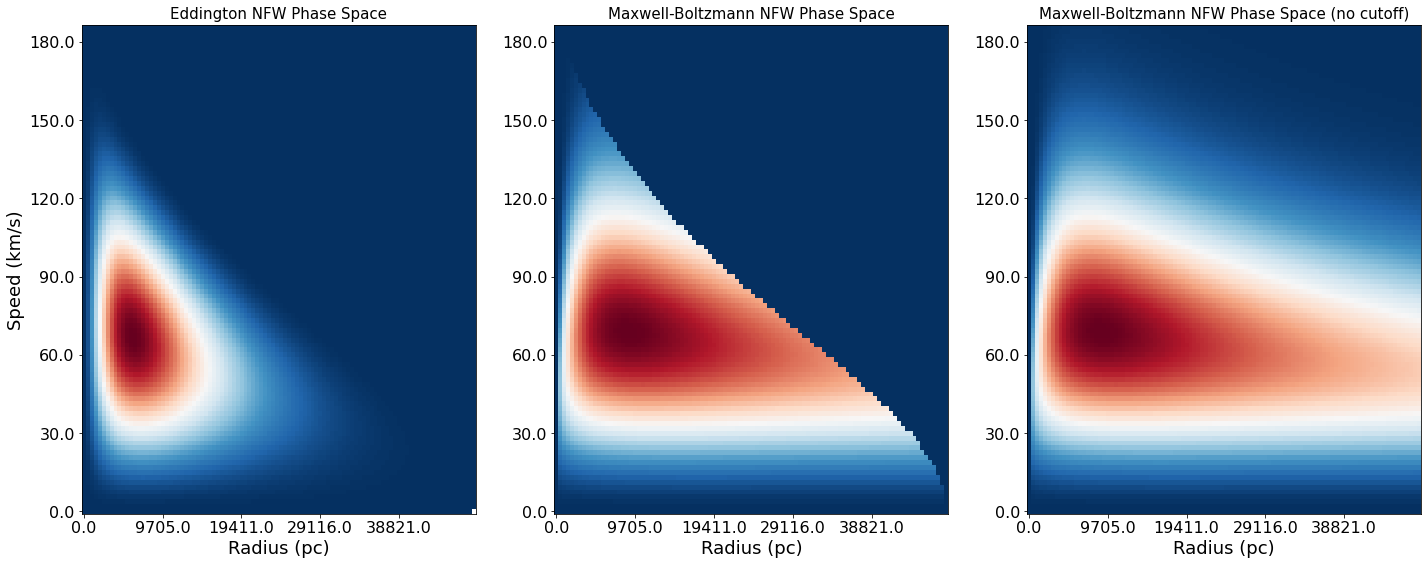

In [77]:
fig, (ax1,ax2,ax3) = plt.subplots(1,3,figsize=(24,9))
ax1.imshow(np.transpose(pdfEddingtonImage),origin='lower',aspect='auto',cmap='RdBu_r')

num_x_labels = 6
step_r = int(nRadii/(num_x_labels-1))
ax1.set_xticks(np.arange(0,nRadii,step_r))
ax1.set_xticklabels(np.round(radii[::step_r]))
ax1.set_xlabel('Radius (pc)')

num_y_labels = 7
step_s = int(nSpeeds/(num_y_labels-1))
ax1.set_yticks(np.arange(0,nSpeeds,step_s))
ax1.set_yticklabels(np.round(speeds[::step_s]))
ax1.set_ylabel('Speed (km/s)')
ax1.set_title('Eddington NFW Phase Space')
#plt.colorbar()

ax2.imshow(np.transpose(pdfMBImage),origin='lower',aspect='auto',cmap='RdBu_r')

num_x_labels = 6
step_r = int(nRadii/(num_x_labels-1))
ax2.set_xticks(np.arange(0,nRadii,step_r))
ax2.set_xticklabels(np.round(radii[::step_r]))
ax2.set_xlabel('Radius (pc)')

num_y_labels = 7
step_s = int(nSpeeds/(num_y_labels-1))
ax2.set_yticks(np.arange(0,nSpeeds,step_s))
ax2.set_yticklabels(np.round(speeds[::step_s]))
ax2.set_title('Maxwell-Boltzmann NFW Phase Space')
#ax2.set_ylabel('Speed (km/s)')

ax3.imshow(np.transpose(pdfMBImageNoCutoff),origin='lower',aspect='auto',cmap='RdBu_r')

num_x_labels = 6
step_r = int(nRadii/(num_x_labels-1))
ax3.set_xticks(np.arange(0,nRadii,step_r))
ax3.set_xticklabels(np.round(radii[::step_r]))
ax3.set_xlabel('Radius (pc)')

num_y_labels = 7
step_s = int(nSpeeds/(num_y_labels-1))
ax3.set_yticks(np.arange(0,nSpeeds,step_s))
ax3.set_yticklabels(np.round(speeds[::step_s]))
ax3.set_title('Maxwell-Boltzmann NFW Phase Space (no cutoff)')
#ax3.set_ylabel('Speed (km/s)')

Text(0.5, 1.0, 'MB speed distribution at r = 33969.0 pc')

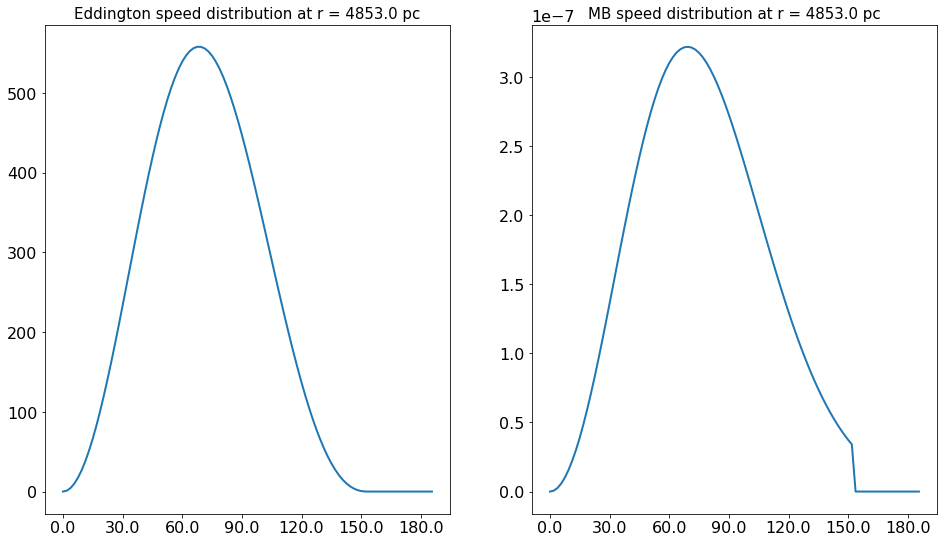

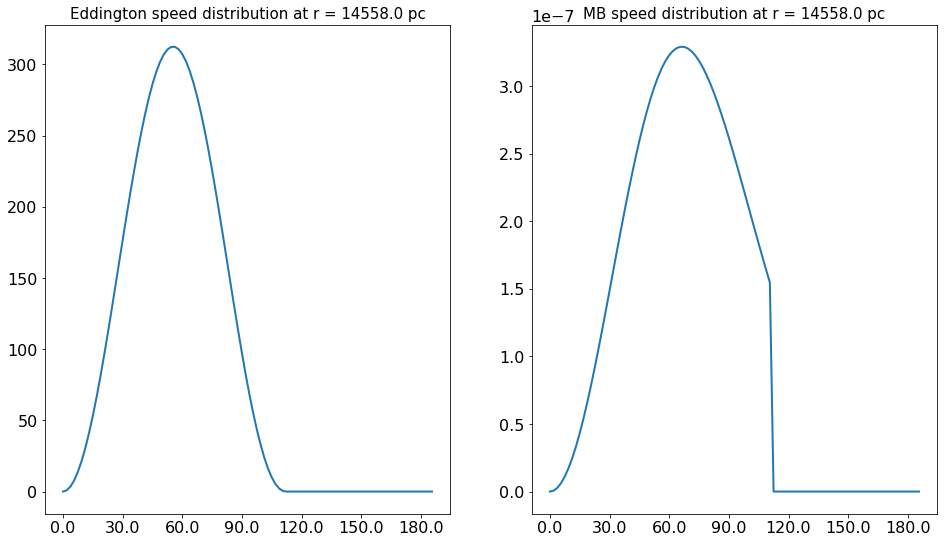

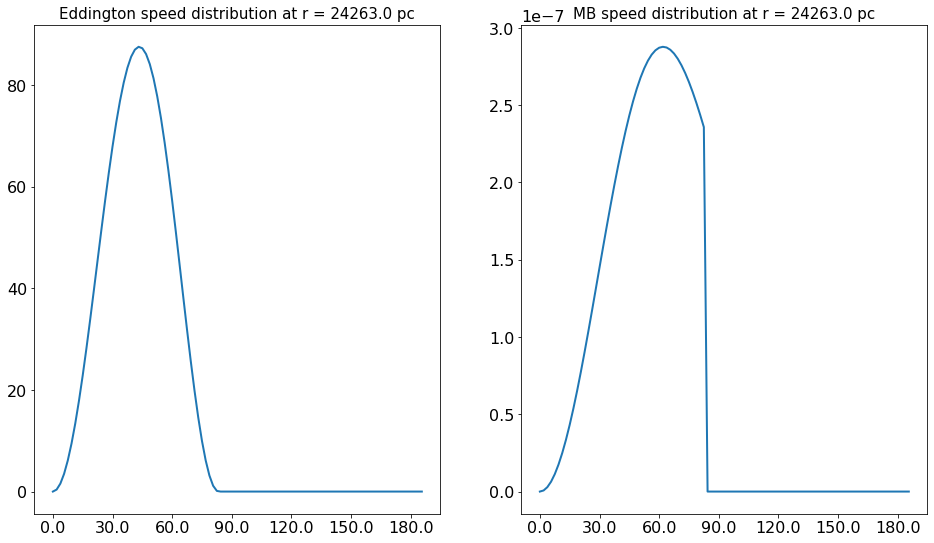

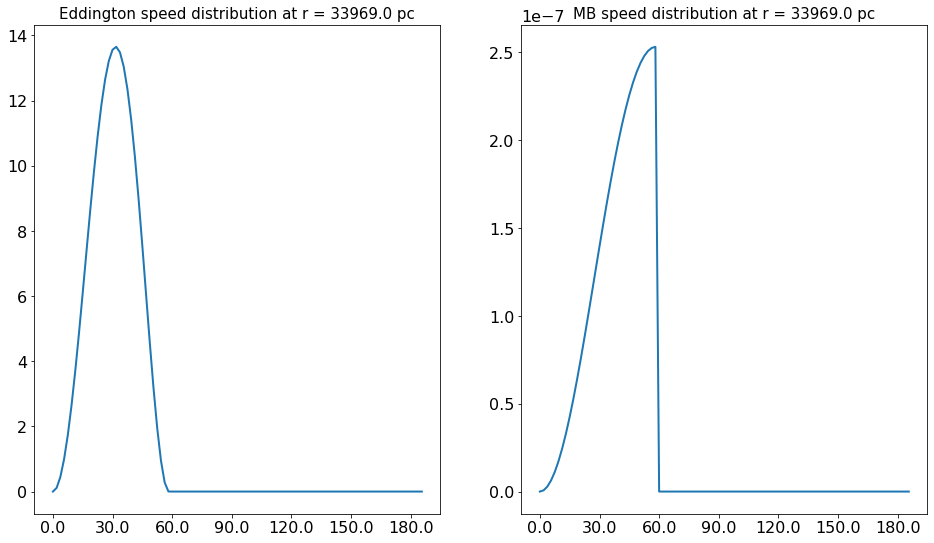

In [84]:
# Slicing at particular radii
fig, (ax1a,ax1b) = plt.subplots(1,2,figsize=(16,9))

num_x_labels = 7
step_s = int(nSpeeds/(num_x_labels-1))


ax1a.plot(pdfEddingtonImage[10,:])
ax1a.set_xticks(np.arange(0,nSpeeds,step_s))
ax1a.set_xticklabels(np.round(speeds[::step_s]))
ax1a.set_title('Eddington speed distribution at r = ' + str(np.round(radii[10])) + ' pc')
ax1b.plot(pdfMBImage[10,:])
ax1b.set_xticks(np.arange(0,nSpeeds,step_s))
ax1b.set_xticklabels(np.round(speeds[::step_s]))
ax1b.set_title('MB speed distribution at r = ' + str(np.round(radii[10])) + ' pc')

fig, (ax2a,ax2b) = plt.subplots(1,2,figsize=(16,9))

ax2a.plot(pdfEddingtonImage[30,:])
ax2a.set_xticks(np.arange(0,nSpeeds,step_s))
ax2a.set_xticklabels(np.round(speeds[::step_s]))
ax2a.set_title('Eddington speed distribution at r = ' + str(np.round(radii[30])) + ' pc')
ax2b.plot(pdfMBImage[30,:])
ax2b.set_xticks(np.arange(0,nSpeeds,step_s))
ax2b.set_xticklabels(np.round(speeds[::step_s]))
ax2b.set_title('MB speed distribution at r = ' + str(np.round(radii[30])) + ' pc')

fig, (ax3a,ax3b) = plt.subplots(1,2,figsize=(16,9))

ax3a.plot(pdfEddingtonImage[50,:])
ax3a.set_xticks(np.arange(0,nSpeeds,step_s))
ax3a.set_xticklabels(np.round(speeds[::step_s]))
ax3a.set_title('Eddington speed distribution at r = ' + str(np.round(radii[50])) + ' pc')
ax3b.plot(pdfMBImage[50,:])
ax3b.set_xticks(np.arange(0,nSpeeds,step_s))
ax3b.set_xticklabels(np.round(speeds[::step_s]))
ax3b.set_title('MB speed distribution at r = ' + str(np.round(radii[50])) + ' pc')

fig, (ax4a,ax4b) = plt.subplots(1,2,figsize=(16,9))

ax4a.plot(pdfEddingtonImage[70,:])
ax4a.set_xticks(np.arange(0,nSpeeds,step_s))
ax4a.set_xticklabels(np.round(speeds[::step_s]))
ax4a.set_title('Eddington speed distribution at r = ' + str(np.round(radii[70])) + ' pc')
ax4b.plot(pdfMBImage[70,:])
ax4b.set_xticks(np.arange(0,nSpeeds,step_s))
ax4b.set_xticklabels(np.round(speeds[::step_s]))
ax4b.set_title('MB speed distribution at r = ' + str(np.round(radii[70])) + ' pc')



In [50]:
radialPDF_Eddington = np.zeros(nRadii)
radialPDF_MB = np.zeros(nRadii)
radialPDF_MB_nocutoff = np.zeros(nRadii)

for i in range(nRadii):
    radialPDF_Eddington[i] = integrate.quad(lambda x: (4*np.pi*radii[i]*x)**2*mwHalo.phaseSpaceDensity(radii[i],x),0,mwHalo.maxSpeed(radii[i]))[0]
    radialPDF_MB[i] = integrate.quad(lambda x: (4*np.pi*radii[i]*x)**2*mwHalo.phaseSpaceDensityMB(radii[i],x),0,mwHalo.maxSpeed(radii[i]))[0]
    #radialPDF_MB_nocutoff[i] = integrate.quad(lambda x: (4*np.pi*radii[i]*x)**2*mwHalo.phaseSpaceDensityMB_noCutoff(radii[i],x),0,np.inf)[0]

<ipython-input-43-c9529f4874f2>:44: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  integrate.quad(lambda y: self.gFcn(y)/(y**3*(1+y)**2), self.c*(r/self.rDelta), np.inf)[0]
<ipython-input-43-c9529f4874f2>:52: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  integrate.quad(lambda y: self.gFcn(y)/(y**3*(1+y)**2), self.c*(r/self.rDelta), np.inf)[0]
<ipython-input-50-2c0c45e1789c>:8: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  radialPDF_MB_nocutoff[i] = integrate.quad(lambda x: (4*np.pi*radii[i]*x)**2*mwHalo.phaseSpaceDensityMB_noCutoff(radii[i],x),0,np.inf)[0]


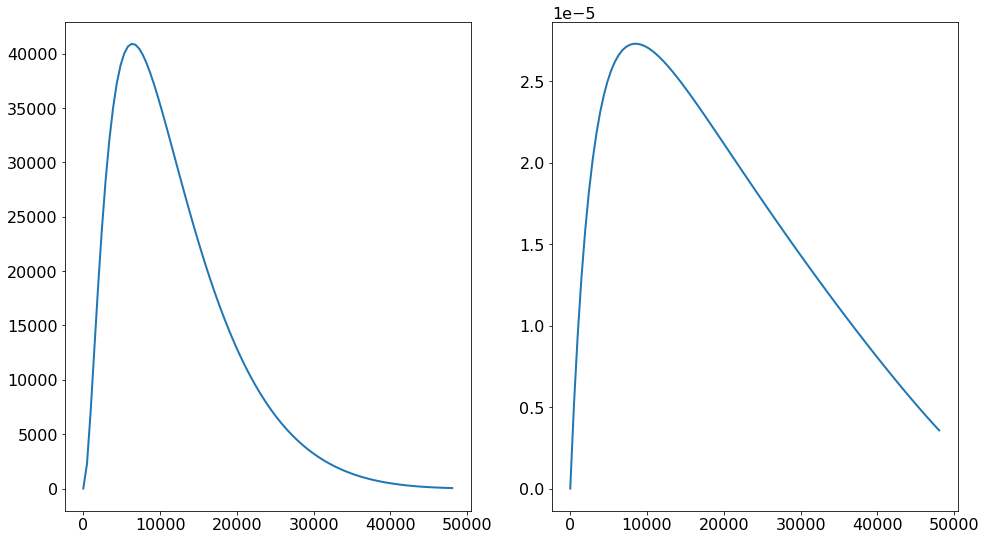

In [75]:
fig, (ax1,ax2) = plt.subplots(1,2,figsize=(16,9))
ax1.plot(radii,radialPDF_Eddington)
ax2.plot(radii,radialPDF_MB)
#plt.plot(radii,radialPDF_MB_nocutoff)